In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xarray as xr
from ALLCools.plot import *

In [2]:
from matplotlib import rc

labelsize = 6
linewidth = 0.6
rc('lines', linewidth=linewidth)
rc('axes', labelsize=labelsize, linewidth=linewidth)
rc('xtick', labelsize=labelsize)
rc('ytick', labelsize=labelsize)
rc('xtick.major', width=linewidth)
rc('ytick.major', width=linewidth)
rc('xtick.minor', width=linewidth-0.2)
rc('ytick.minor', width=linewidth-0.2)
rc('patch', linewidth=linewidth)

In [3]:
use_genes = pd.read_csv('use_genes.txt', header=None, index_col=0).index
gene_meta = pd.read_csv(
    '/home/hanliu/ref/mouse/gencode/vm22/gencode.vM22.annotation.gene.flat.tsv.gz',
    index_col='gene_id',
    sep='\t')
gene_meta.index.name = 'gene'
gene_name_to_id = {v: k for k, v in gene_meta['gene_name'].iteritems()}
gene_idbase_to_id = {i.split('.')[0]: i for i in gene_meta.index}


In [4]:
cell_tidy_data = pd.read_msgpack(
    '/home/hanliu/project/mouse_rostral_brain/study/ClusteringSummary/Summary/TotalClusteringResults.msg'
)
cell_tidy_data = cell_tidy_data[
    cell_tidy_data['SubType'].apply(lambda i: 'Outlier' not in i)
    & (cell_tidy_data['CellClass'] != 'NonN')].copy()

/home/hanliu/miniconda3/envs/clustering/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: FutureWarning: The read_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/dissection_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_region_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_region.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

cell_class_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/cell_class.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
major_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/major_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()
sub_type_palette = pd.read_csv('/home/hanliu/project/mouse_rostral_brain/metadata/palette/sub_type.palette.csv',
                                header=None, index_col=0, squeeze=True).to_dict()

for sub_type in cell_tidy_data['SubType'].unique():
    if sub_type not in sub_type_palette:
        # outlier and NA color
        sub_type_palette[sub_type] = '#D3D3D3'

In [ ]:
mcds = xr.open_mfdataset(
    '/home/hanliu/project/mouse_rostral_brain/study/Level1-CellClass/ALL_manual/Adata/SelectedCell.gene_da_rate.*.mcds',
    combine='nested', concat_dim='cell'
)['gene_da'].sel(gene=[gene_name_to_id[i] for i in use_genes]).load()
mcds.to_netcdf('use_genes.nc')

In [6]:
mcds = xr.open_dataset('use_genes.nc').load()
gene_data = mcds['gene_da'].sel(mc_type='CHN', cell=cell_tidy_data.index).to_pandas()
gene_data = gene_data.loc[:, ~gene_data.columns.duplicated()].copy()
gene_data.columns = gene_data.columns.map(gene_meta['gene_name'])
cell_tidy_data = pd.concat([cell_tidy_data, gene_data], sort=True, axis=1)

## CA1

In [7]:
major_type = 'CA1'
subtypes = ['CA1 Chrm3', 'CA1 Ptprg', 'CA1 Kif26a', 'CA1 Ak5', 'CA1 Lingo2']
genes = ['Chrm3', 'Ptprg', 'Kif26a', 'Ak5', 'Lingo2']
s = 1
outline_pad = 0.5

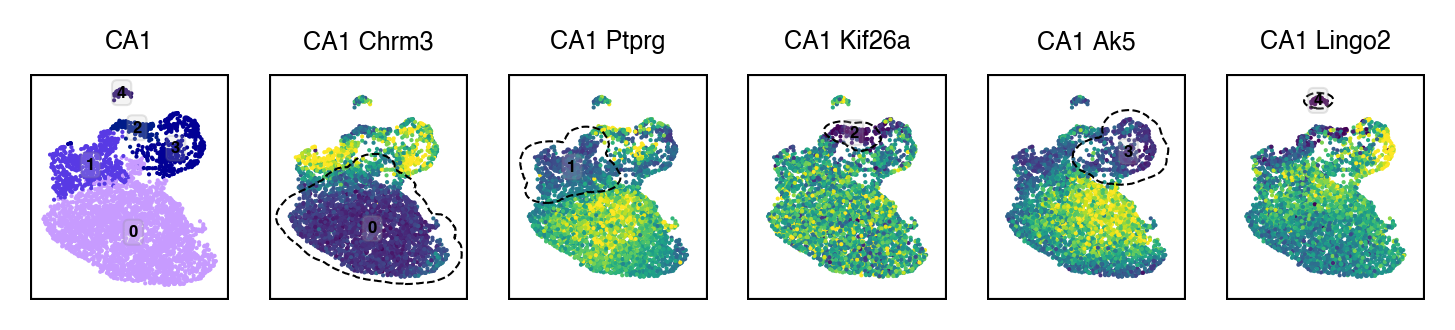

In [8]:
assert len(subtypes) == len(genes)

sub_df = cell_tidy_data[cell_tidy_data['MajorType'] == major_type].copy()
n_subtype = sub_df['SubType'].unique().size

subtype_map = pd.Series(
    {st: i
     for i, st in enumerate(sub_df['SubType'].unique())})
sub_df['SubTypeInt'] = sub_df['SubType'].map(subtype_map)

fig, axes = plt.subplots(figsize=(n_subtype + 1, 1),
                         dpi=300,
                         ncols=n_subtype + 1)

ax = axes[0]
categorical_scatter(
    data=sub_df,
    ax=ax,
    hue='SubType',
    palette=sub_type_palette,
    #outline='SubType',
    #outline_pad=outline_pad,
    #outline_kws=dict(linewidth=0.5),
    text_anno='SubTypeInt',
    s=s,
    coord_base='l3-umap',
    axis_format=None)
ax.set_title(major_type, fontsize=labelsize)
add_ax_box(ax)

for ax, subtype, gene in zip(axes[1:], subtypes, genes):
    sub_df['ThisInt'] = sub_df['SubTypeInt'].apply(lambda i: str(
        i) if i == subtype_map[subtype] else np.NaN)
    continuous_scatter(data=sub_df,
                       ax=ax,
                       hue=gene,
                       #hue_norm=(0, 2),
                       hue_portion=0.95,
                       outline='ThisInt',
                       outline_pad=outline_pad,
                       outline_kws=dict(linewidth=0.5, c='k'),
                       text_anno='ThisInt',
                       s=s,
                       coord_base='l3-umap',
                       axis_format=None,
                       colorbar=None)
    ax.set_title(subtype, fontsize=labelsize)
    add_ax_box(ax)

pass

## CA3

In [9]:
major_type = 'CA3'
subtypes = ['CA3 Cadm2', 'CA3 Efnb2']
genes = ['Cadm2', 'Efnb2']
s = 1
outline_pad = 0.5

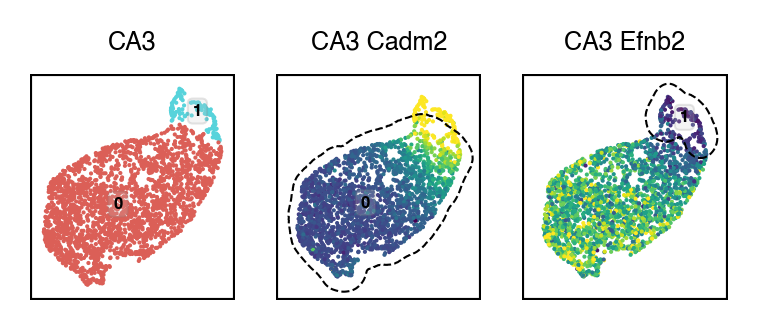

In [10]:
assert len(subtypes) == len(genes)

sub_df = cell_tidy_data[cell_tidy_data['MajorType'] == major_type].copy()
n_subtype = sub_df['SubType'].unique().size

subtype_map = pd.Series(
    {st: i
     for i, st in enumerate(sub_df['SubType'].unique())})
sub_df['SubTypeInt'] = sub_df['SubType'].map(subtype_map)

fig, axes = plt.subplots(figsize=(n_subtype + 1, 1),
                         dpi=300,
                         ncols=n_subtype + 1)

ax = axes[0]
categorical_scatter(
    data=sub_df,
    ax=ax,
    hue='SubType',
    palette='hls',
    #outline='SubType',
    #outline_pad=outline_pad,
    #outline_kws=dict(linewidth=0.5),
    text_anno='SubTypeInt',
    s=s,
    coord_base='l3-umap',
    axis_format=None)
ax.set_title(major_type, fontsize=labelsize)
add_ax_box(ax)

for ax, subtype, gene in zip(axes[1:], subtypes, genes):
    sub_df['ThisInt'] = sub_df['SubTypeInt'].apply(lambda i: str(
        i) if i == subtype_map[subtype] else np.NaN)
    continuous_scatter(data=sub_df,
                       ax=ax,
                       hue=gene,
                       #hue_norm=(0, 2),
                       hue_portion=0.95,
                       outline='ThisInt',
                       outline_pad=outline_pad,
                       outline_kws=dict(linewidth=0.5, c='k'),
                       text_anno='ThisInt',
                       s=s,
                       coord_base='l3-umap',
                       axis_format=None,
                       colorbar=None)
    ax.set_title(subtype, fontsize=labelsize)
    add_ax_box(ax)

pass

## CA3-St18

In [11]:
major_type = 'CA3-St18'
subtypes = ['CA3-St18 Tead1', 'CA3-St18 Nuak1', 'CA3-St18 Epha5']
genes = ['Tead1', 'Nuak1', 'Epha5']
s = 3
outline_pad = -.1


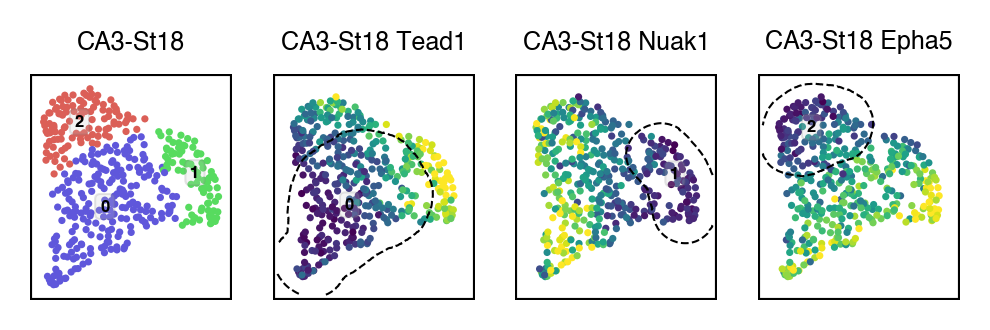

In [12]:
assert len(subtypes) == len(genes)

sub_df = cell_tidy_data[cell_tidy_data['MajorType'] == major_type].copy()
n_subtype = sub_df['SubType'].unique().size

subtype_map = pd.Series(
    {st: i
     for i, st in enumerate(sub_df['SubType'].unique())})
sub_df['SubTypeInt'] = sub_df['SubType'].map(subtype_map)

fig, axes = plt.subplots(figsize=(n_subtype + 1, 1),
                         dpi=300,
                         ncols=n_subtype + 1)

ax = axes[0]
categorical_scatter(
    data=sub_df,
    ax=ax,
    hue='SubType',
    palette='hls',
    #outline='SubType',
    #outline_pad=outline_pad,
    #outline_kws=dict(linewidth=0.5),
    text_anno='SubTypeInt',
    s=s,
    coord_base='l3-umap',
    axis_format=None)
ax.set_title(major_type, fontsize=labelsize)
add_ax_box(ax)

for ax, subtype, gene in zip(axes[1:], subtypes, genes):
    sub_df['ThisInt'] = sub_df['SubTypeInt'].apply(lambda i: str(
        i) if i == subtype_map[subtype] else np.NaN)
    continuous_scatter(data=sub_df,
                       ax=ax,
                       hue=gene,
                       #hue_norm=(0, 2),
                       hue_portion=0.95,
                       outline='ThisInt',
                       outline_pad=outline_pad,
                       outline_kws=dict(linewidth=0.5, c='k'),
                       text_anno='ThisInt',
                       s=s,
                       coord_base='l3-umap',
                       axis_format=None,
                       colorbar=None)
    ax.set_title(subtype, fontsize=labelsize)
    add_ax_box(ax)

pass

## CGE-Lamp5

In [13]:
major_type = 'CGE-Lamp5'
subtypes = ['CGE-Lamp5 Dock5', 'CGE-Lamp5 Grk5', 'CGE-Lamp5 Sorcs1', 'CGE-Lamp5 Grid1', 'CGE-Lamp5 Nrxn3']
genes = ['Dock5', 'Grk5', 'Sorcs1', 'Grid1', 'Nrxn3']
s = 1
outline_pad = -.1


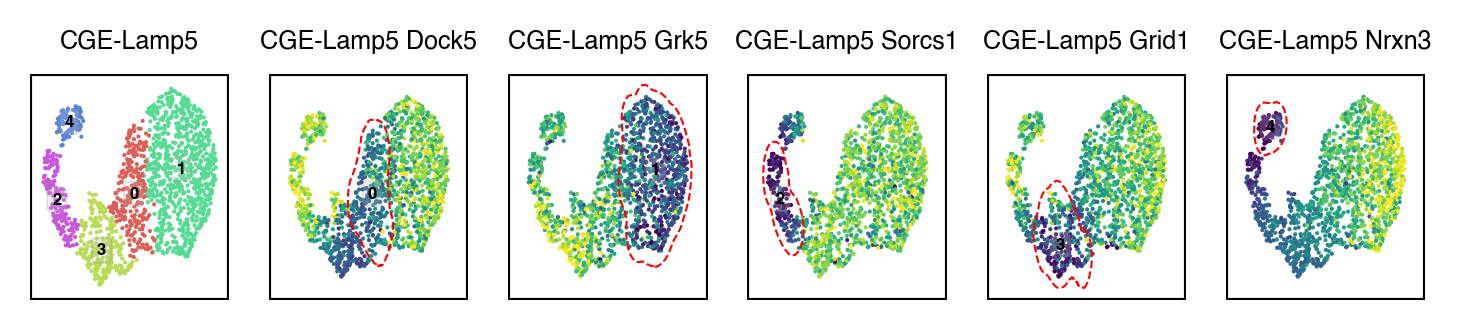

In [14]:
assert len(subtypes) == len(genes)

sub_df = cell_tidy_data[cell_tidy_data['MajorType'] == major_type].copy()
n_subtype = sub_df['SubType'].unique().size

subtype_map = pd.Series(
    {st: i
     for i, st in enumerate(sub_df['SubType'].unique())})
sub_df['SubTypeInt'] = sub_df['SubType'].map(subtype_map)

fig, axes = plt.subplots(figsize=(n_subtype + 1, 1),
                         dpi=300,
                         ncols=n_subtype + 1)

ax = axes[0]
categorical_scatter(
    data=sub_df,
    ax=ax,
    hue='SubType',
    palette='hls',
    #outline='SubType',
    #outline_pad=outline_pad,
    #outline_kws=dict(linewidth=0.5),
    text_anno='SubTypeInt',
    s=s,
    coord_base='l3-umap',
    axis_format=None)
ax.set_title(major_type, fontsize=labelsize)
add_ax_box(ax)

for ax, subtype, gene in zip(axes[1:], subtypes, genes):
    sub_df['ThisInt'] = sub_df['SubTypeInt'].apply(lambda i: str(
        i) if i == subtype_map[subtype] else np.NaN)
    continuous_scatter(data=sub_df,
                       ax=ax,
                       hue=gene,
                       #hue_norm=(0, 2),
                       hue_portion=0.95,
                       outline='ThisInt',
                       outline_pad=outline_pad,
                       outline_kws=dict(linewidth=0.5, c='r'),
                       text_anno='ThisInt',
                       s=s,
                       coord_base='l3-umap',
                       axis_format=None,
                       colorbar=None)
    ax.set_title(subtype, fontsize=labelsize)
    add_ax_box(ax)

pass

## CGE-Vip

In [15]:
major_type = 'CGE-Vip'
subtypes = ['CGE-Vip Ntng1', 'CGE-Vip Ptprm', 'CGE-Vip Robo1', 'CGE-Vip Grm8', 'CGE-Vip Ccser1', 'CGE-Vip Fstl4', 'CGE-Vip Galnt17', 'CGE-Vip Clstn2']
genes = ['Ntng1', 'Ptprm', 'Robo1', 'Grm8', 'Ccser1', 'Fstl4', 'Galnt17', 'Clstn2']
s = 1
outline_pad = 0


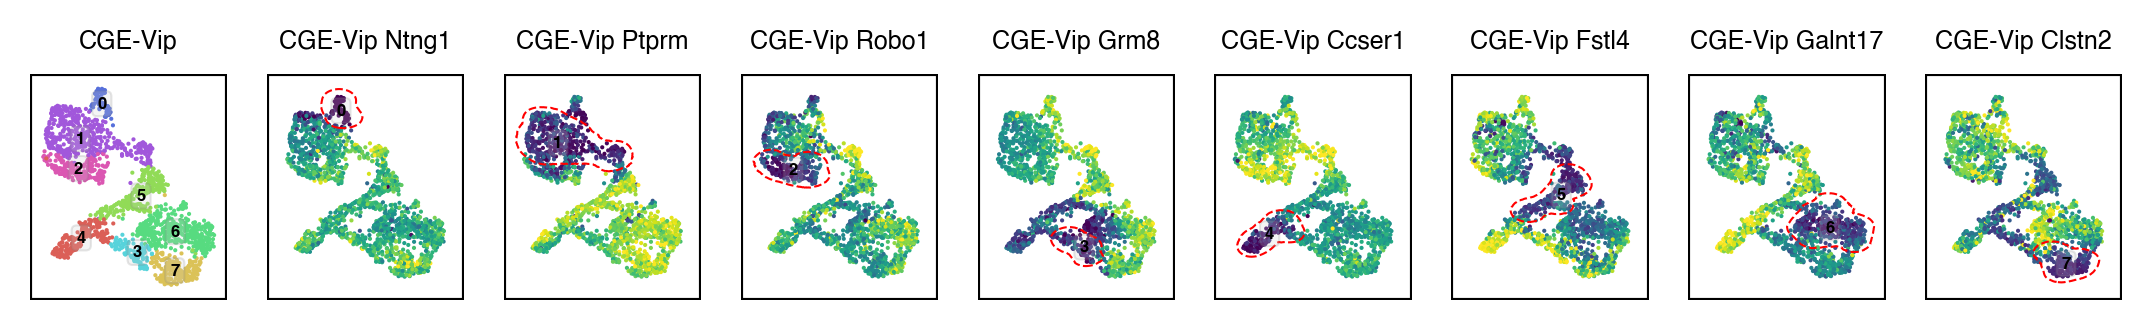

In [16]:
assert len(subtypes) == len(genes)

sub_df = cell_tidy_data[cell_tidy_data['MajorType'] == major_type].copy()
n_subtype = sub_df['SubType'].unique().size

subtype_map = pd.Series(
    {st: i
     for i, st in enumerate(sub_df['SubType'].unique())})
sub_df['SubTypeInt'] = sub_df['SubType'].map(subtype_map)

fig, axes = plt.subplots(figsize=(n_subtype + 1, 1),
                         dpi=300,
                         ncols=n_subtype + 1)

ax = axes[0]
categorical_scatter(
    data=sub_df,
    ax=ax,
    hue='SubType',
    palette='hls',
    #outline='SubType',
    #outline_pad=outline_pad,
    #outline_kws=dict(linewidth=0.5),
    text_anno='SubTypeInt',
    s=s,
    coord_base='l3-umap',
    axis_format=None)
ax.set_title(major_type, fontsize=labelsize)
add_ax_box(ax)

for ax, subtype, gene in zip(axes[1:], subtypes, genes):
    sub_df['ThisInt'] = sub_df['SubTypeInt'].apply(lambda i: str(
        i) if i == subtype_map[subtype] else np.NaN)
    continuous_scatter(data=sub_df,
                       ax=ax,
                       hue=gene,
                       #hue_norm=(0, 2),
                       hue_portion=0.95,
                       outline='ThisInt',
                       outline_pad=outline_pad,
                       outline_kws=dict(linewidth=0.5, c='r'),
                       text_anno='ThisInt',
                       s=s,
                       coord_base='l3-umap',
                       axis_format=None,
                       colorbar=None)
    ax.set_title(subtype, fontsize=labelsize)
    add_ax_box(ax)

pass

In [18]:
major_type = 'CLA'
subtypes = ['CLA Bcl11a', 'CLA Cdh8', 'CLA Nrp2']
genes = ['Bcl11a', 'Cdh8', 'Nrp2']

s = 1
outline_pad = 0


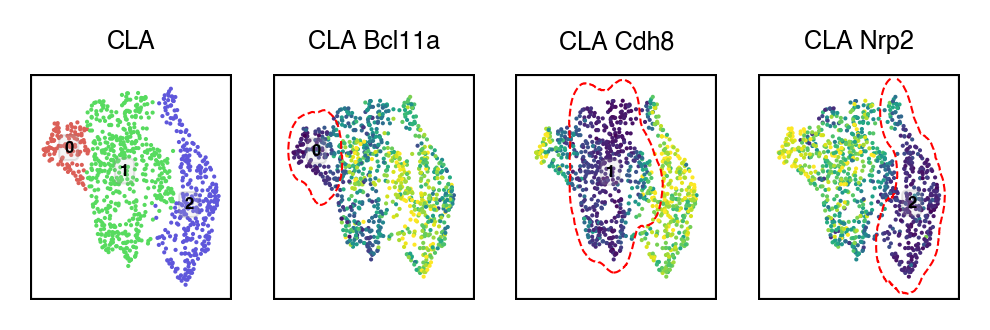

In [19]:
assert len(subtypes) == len(genes)

sub_df = cell_tidy_data[cell_tidy_data['MajorType'] == major_type].copy()
n_subtype = sub_df['SubType'].unique().size

subtype_map = pd.Series(
    {st: i
     for i, st in enumerate(sub_df['SubType'].unique())})
sub_df['SubTypeInt'] = sub_df['SubType'].map(subtype_map)

fig, axes = plt.subplots(figsize=(n_subtype + 1, 1),
                         dpi=300,
                         ncols=n_subtype + 1)

ax = axes[0]
categorical_scatter(
    data=sub_df,
    ax=ax,
    hue='SubType',
    palette='hls',
    #outline='SubType',
    #outline_pad=outline_pad,
    #outline_kws=dict(linewidth=0.5),
    text_anno='SubTypeInt',
    s=s,
    coord_base='l3-umap',
    axis_format=None)
ax.set_title(major_type, fontsize=labelsize)
add_ax_box(ax)

for ax, subtype, gene in zip(axes[1:], subtypes, genes):
    sub_df['ThisInt'] = sub_df['SubTypeInt'].apply(lambda i: str(
        i) if i == subtype_map[subtype] else np.NaN)
    continuous_scatter(data=sub_df,
                       ax=ax,
                       hue=gene,
                       #hue_norm=(0, 2),
                       hue_portion=0.95,
                       outline='ThisInt',
                       outline_pad=outline_pad,
                       outline_kws=dict(linewidth=0.5, c='r'),
                       text_anno='ThisInt',
                       s=s,
                       coord_base='l3-umap',
                       axis_format=None,
                       colorbar=None)
    ax.set_title(subtype, fontsize=labelsize)
    add_ax_box(ax)

pass

In [17]:
for major_type, sub_df in cell_tidy_data[cell_tidy_data['CellClass'] == 'Exc'].groupby('MajorType'):
    print(major_type)
    print(list(sub_df['SubType'].unique()))
    print(list(map(lambda i: i.split(' ')[-1], sub_df['SubType'].unique())))

CA1
['CA1 Chrm3', 'CA1 Ptprg', 'CA1 Kif26a', 'CA1 Ak5', 'CA1 Lingo2']
['Chrm3', 'Ptprg', 'Kif26a', 'Ak5', 'Lingo2']
CA3
['CA3 Cadm2', 'CA3 Efnb2']
['Cadm2', 'Efnb2']
CA3-St18
['CA3-St18 Tead1', 'CA3-St18 Nuak1', 'CA3-St18 Epha5']
['Tead1', 'Nuak1', 'Epha5']
CLA
['CLA Bcl11a', 'CLA Cdh8', 'CLA Nrp2']
['Bcl11a', 'Cdh8', 'Nrp2']
CT-L6
['CT-L6 Megf9', 'CT-L6 Il1rap', 'CT-L6 Hcrtr2', 'CT-L6 Map4']
['Megf9', 'Il1rap', 'Hcrtr2', 'Map4']
DG
['DG dg-all']
['dg-all']
DG-po
['DG-po Calb2', 'DG-po Bcl11a', 'DG-po Kctd8']
['Calb2', 'Bcl11a', 'Kctd8']
EP
['EP Tspan5', 'EP Rgs8', 'EP Adcy8']
['Tspan5', 'Rgs8', 'Adcy8']
Gfra1
['Gfra1 Gfra1']
['Gfra1']
IG-CA2
['IG-CA2 Chrm3', 'IG-CA2 Peak1', 'IG-CA2 Xpr1']
['Chrm3', 'Peak1', 'Xpr1']
IT-L23
['IT-L23 Cux1', 'IT-L23 Foxp1', 'IT-L23 Tenm2', 'IT-L23 Ptprt']
['Cux1', 'Foxp1', 'Tenm2', 'Ptprt']
IT-L4
['IT-L4 Shc3', 'IT-L4 Astn2']
['Shc3', 'Astn2']
IT-L5
['IT-L5 Etv1', 'IT-L5 Cdh8', 'IT-L5 Grik3']
['Etv1', 'Cdh8', 'Grik3']
IT-L6
['IT-L6 Man1c1', 'IT-L6 Fstl4',